In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

In [2]:
path = './data/disagg_struct_refs/sources/US/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['Cropland','Cropland'],
                                ['Desert','Desert'],
                                ['Grassland','Grassland'],
                                ['Other','Other'],
                                ['Woodland','Woodland'],
                                ['Urban','Urban'],
                                ['Water','Water']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [3]:
X_area_cluster = pd.read_csv('./data/X_county_cluster.csv', index_col=0)
X_area_cluster.index = X_area_cluster.index.astype(str).str.zfill(5)

In [4]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties = counties.set_index('area_fips')[['geometry']]

In [5]:
gdf = gpd.GeoDataFrame(pd.concat([X_area_cluster, counties], axis = 1, sort = True).dropna())
gdf.columns = list(gdf.columns[:-1].values.astype(float).astype(int).astype(str)) + ['geometry']
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs({'init': 'epsg:3395'})

In [6]:
gdf_scaled = gdf.copy()
gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1].div(gdf_scaled.iloc[:, :-1].sum(1), 0)
# gdf_scaled.iloc[:, :-1] = (gdf_scaled.iloc[:, :-1]/gdf_scaled.iloc[:, :-1].median()).dropna(1)
gdf_scaled.iloc[:, :-1] = np.log10(gdf_scaled.iloc[:, :-1] + 0.1)

In [7]:
gdf_scaled = gdf.copy()
M = gdf_scaled.iloc[:, :-1].fillna(.01)
gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum())
# M.sum(1)

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [8]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
X = df_cnt.unstack()['annual_avg_estabs']
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

X.shape

(3272, 318)

In [9]:
# M = X.fillna(.0001)
# M = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum())
# log_RCA = M.stack().reset_index().rename(columns = {0: 'log_RCA'})
# x = np.log10(X).stack().reset_index().rename(columns = {0: 'no_estabs'})

# x_RCA = log_RCA.merge(x).replace(-np.inf, np.nan)
# x_RCA.plot(x = 'log_RCA', y = 'no_estabs', marker = '.', lw = 0, alpha = .01)

In [10]:
# gdf_max.reset_index()[['area_fips', 'cluster']].head()

In [11]:
# clusters.head()

In [12]:
# clusters = pd.read_csv('./data/clusters.csv').drop('cluster', 1)
# clusters['industry_code'] = clusters.industry_code.astype(str)

# max_cluster_data = gdf_max.reset_index()[['area_fips', 'cluster']].merge(clusters) # areas only keep indus in their painting cluster

# x_RCA['level'] = 5*x_RCA['no_estabs'] + x_RCA['log_RCA']

# data = x_RCA.merge(max_cluster_data)
# data = data.loc[(data.log_RCA > 0) & (data.no_estabs > 0)]

# # max_cluster_data.head()
# data.groupby('area_fips').apply(lambda x: x.nlargest(5, 'no_estabs'))

In [13]:
# Y = gdf.drop('geometry', axis = 1)#.sum().sum()/1e6
# M

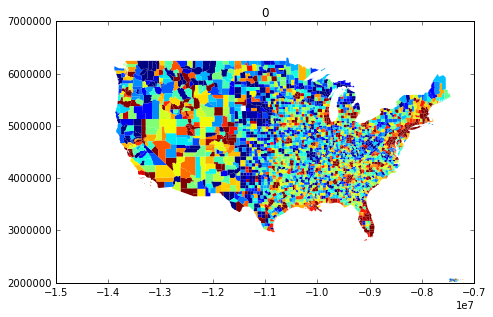

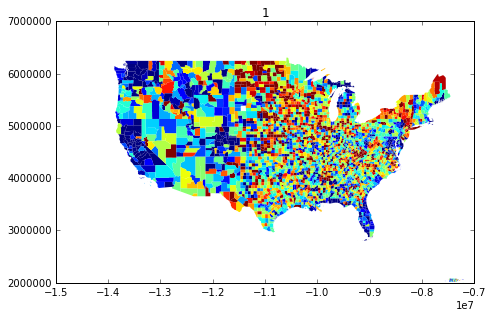

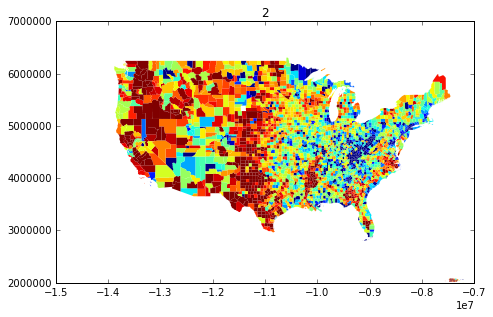

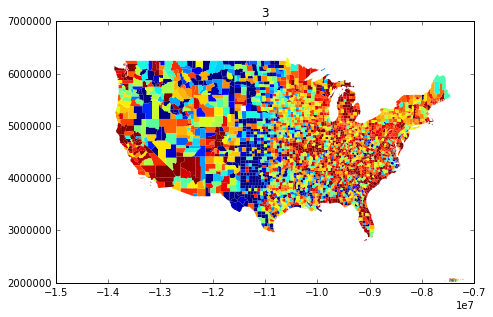

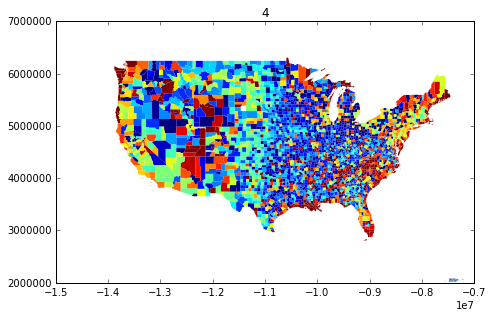

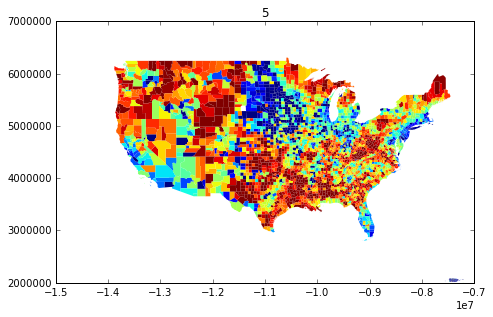

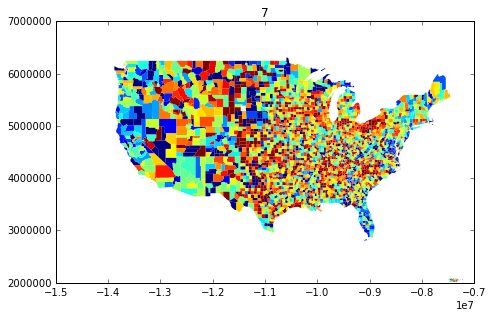

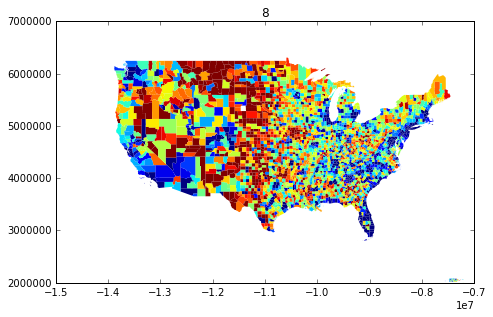

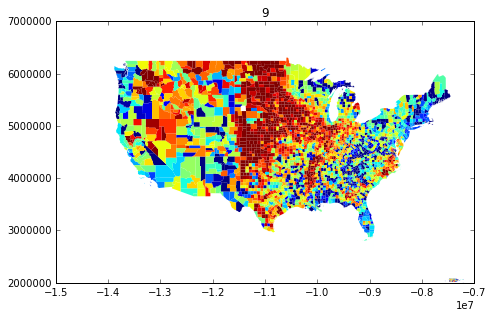

In [15]:
gdf_scaled = gdf.copy()
M = gdf_scaled.iloc[:, :-1].fillna(.01) + 0.01
gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum())

for col in gdf_scaled.iloc[:, :-1].columns:
    ax = gdf_scaled.plot(column = col, cmap=plt.cm.jet, 
                         vmin = gdf_scaled[col].quantile(.1), vmax = gdf_scaled[col].quantile(.9), 
                         linewidth = 0, figsize = (7.5, 6))
    ax.set_title(col)
    ax.set_xlim(-1.5e7, -.7e7)
    ax.set_ylim(.2e7, .7e7)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#     ax.axis('off')
    plt.show()

In [16]:
ranks = gdf_scaled.iloc[:, :-1].rank(axis = 1, ascending = False)
argmax = (ranks == 1).astype(int).stack()
argmax = argmax.loc[argmax == 1].reset_index().drop(0, 1)
argmax.columns = ['area_fips', 'cluster']

gdf_max = gpd.GeoDataFrame(pd.concat([argmax.set_index('area_fips'), gdf.geometry], axis = 1))

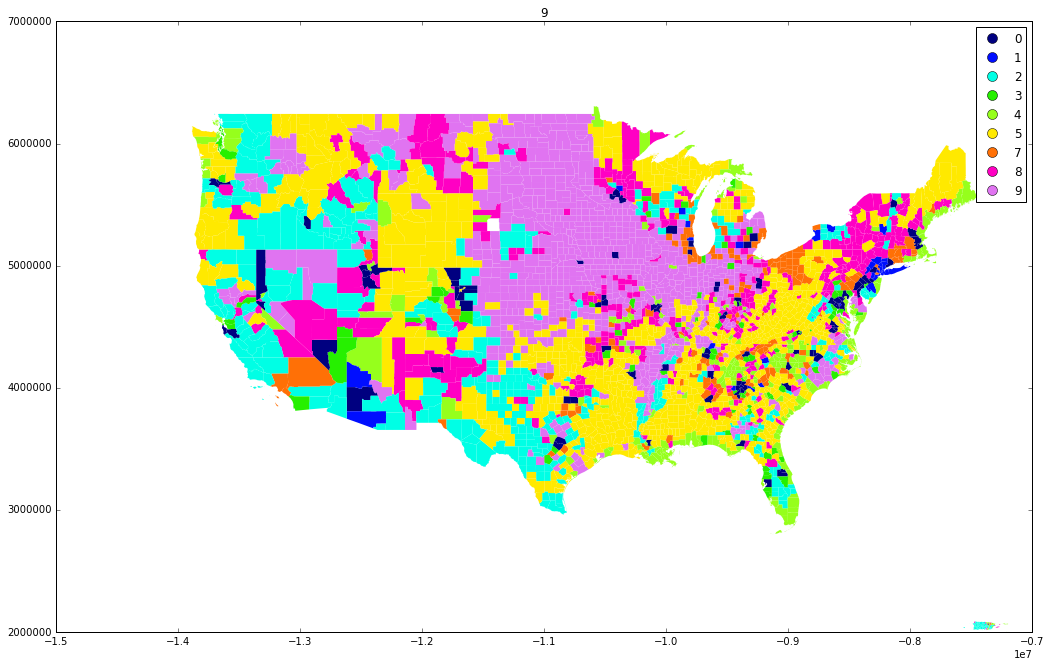

In [17]:
ax = gdf_max.plot('cluster', cmap=plt.cm.gist_ncar, legend=True,
                         vmin = 0, vmax = 9, 
                         linewidth = 0, figsize = (17.5, 12))
ax.set_title(col)
ax.set_xlim(-1.5e7, -.7e7)
ax.set_ylim(.2e7, .7e7)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#     ax.axis('off')
plt.show()

## online mapping

In [ ]:
import os

def save_geojson(gdf, filename = 'test.geojson'):
    try:    # Delete if geojson exists, cause overwriting is not supported
        os.remove('./geojson/'+filename)
    except OSError:
        pass
    
    gdf.to_file('./geojson/'+filename, driver="GeoJSON", encoding='utf-8')
    
from mapbox import Uploader
import json

def upload_file(data, name, username = 'matuteiglesias', token = 'sk.eyJ1IjoibWF0dXRlaWdsZXNpYXMiLCJhIjoiY2puODA4bW8xMGV1dzNrcGtiOGp6NXQ5aCJ9.DohKmjn_o6MK1Y4Q5FG8ew'):
    try:    # Clear upload file if exists
        os.remove('./upload_data.geojson')
    except OSError:
        pass
    
    # Dump into file for upload    
    with open('./upload_data.geojson', 'w') as outfile:
        json.dump(data, outfile)

    service = Uploader(access_token=token)
    with open('./upload_data.geojson', 'rb') as src:
        # Acquisition of credentials, staging of data, and upload
        # finalization is done by a single method in the Python SDK.
        upload_resp = service.upload(src, username+'.'+name)
        

In [ ]:
# gdf_max.crs = {'init': 'epsg:3395'}
# gdf_max = gdf_max.to_crs({'init': 'epsg:4326'})

gdf_max['cluster'] = gdf_max['cluster'].astype(int)

save_geojson(gdf_max, 'cluster_max_2.geojson')

In [ ]:
gdf_scaled = gdf.copy()
M = gdf_scaled.iloc[:, :-1].fillna(.01) + 0.01
gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum())

gdf_scaled.crs = {'init': 'epsg:3395'}
gdf_scaled = gdf_scaled.to_crs({'init': 'epsg:4326'})

save_geojson(gdf_scaled, 'cluster_max_5.geojson')

In [ ]:
username = 'matuteiglesias'
token = 'sk.eyJ1IjoibWF0dXRlaWdsZXNpYXMiLCJhIjoiY2puODA4bW8xMGV1dzNrcGtiOGp6NXQ5aCJ9.DohKmjn_o6MK1Y4Q5FG8ew'

files = os.listdir('./geojson/')
files = [f for f in files if 'cluster_max_5' in f]

names = [name.split('.')[0] for name in files]

for i in range(len(files)):
    print(names[i])
    data = json.load(open('./geojson/'+files[i]))

    try:
        upload_file(data, names[i])
    except:
        pass

In [ ]:
# gdf_max.crs = {'init': 'epsg:3395'}
# gdf_scaled = gdf_scaled.head().to_crs({'init': 'epsg:4326'})

In [ ]:
gdf_scaled